In [5]:
import requests
from bs4 import BeautifulSoup
import re, urllib, json
import pandas as pd

In [66]:
def get_character_text(name):

    baseurl = "https://theoffice.fandom.com/api.php?"
    action = "action=query"
    title = f"titles={name}"
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat = "format=json"

    query = "{0}{1}&{2}&{3}&{4}".format(baseurl,action,title,content,dataformat)


    with open(f'Data/characters/{name}.txt', 'w') as f:

        response = urllib.request.urlopen(query)
        data = response.read()
        text = data.decode('utf-8')
        content = json.loads(text)
        page_id = list(content['query']['pages'].keys())[0]
        text = content['query']['pages'][page_id]['revisions'][0]['slots']['main']['*']
        
        # Remvoe non-unicode characters
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        f.write(text)

In [67]:
# characters are split across two pages
page_titles = ["https://theoffice.fandom.com/wiki/Category:Characters", "https://theoffice.fandom.com/wiki/Category:Characters?from=Merv+Bronte"]
categories = []

for page_title in page_titles:

    title = f"titles={page_title}"
    query = "{}{}&{}&{}&{}&rvslots=*".format(baseurl, action, content, title, dataformat)

    page = requests.get(page_title)

    soup = BeautifulSoup(page.content, "html.parser")
    character_pattern = re.compile(r'/wiki/(.*)')
    category_pattern = re.compile(r'Category:')
    filter_subcategories = ["Background_Employees", "Clients_of_Dunder_Mifflin", "Main_Characters", "Mentioned_characters", "Voiced_Characters", "Background_Warehouse_Employees", "Dunder_Mifflin_family_members_and_loved_ones", "The_Office_Characters", "Angela%27s_cats"]
    # for each of the characters listed in the characters pages
    for link in soup.find_all("a", {"class": "category-page__member-link"}):

        # capture all the href elements
        href = link.get("href")

        # capture all character names in each href
        name =  character_pattern.match(href).group(1)

        # remove "Categories" which are classifications of characters and not characters themselves
        if category_pattern.match(name):
            categories.append(name)

        # remove specific subcategories which are not characters themselves
        elif name not in filter_subcategories:
            get_character_text(name)


Add category to character

In [70]:
baseurl = "https://theoffice.fandom.com/api.php?"
action = "action=query"
list_ = "list=categorymembers"
cmlimit = "cmlimit=500"
dataformat ="format=json"

categories = {                
             'Main_Characters': 0,
             'Warehouse_worker': 1,
             'Former_employees': 2,
             'Background_employees': 3,
             'IT_Guys': 4,
             'Family_members': 5,
             'Characters_of_Michael_Scott': 6,
             'Characters_of_Dwight_Schrute': 7,
             'Threat_Level_Midnight_Characters': 8,
             'The_3rd_Floor_Characters': 9,
             'Deceased_characters': 10,
             'Animals': 11,
             'Unseen_Characters': 12,
             'Unnamed': 13, 
             'Dunder_Mifflin_employees':14
             }

queries = []
for category in categories:
    cmtitle = f"cmtitle=Category:{category}"
    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, list_, cmtitle, cmlimit, dataformat)
    queries.append(query)

    
characters_category = {}
for category, query in zip(categories,queries):
    response = urllib.request.urlopen(query)
    data = response.read()
    text = data.decode('utf-8')
    
    json_text = json.loads(text)
    
    category_members = json_text["query"]["categorymembers"]
    
    characters = [member["title"] for member in category_members]
    
    for character in characters:
        if character not in characters_category.keys() and "Category" not in character:
            characters_category[character] = category
            

df = pd.DataFrame({"Category" : characters_category.values()}, index = characters_category.keys())
df.to_csv("Data/dataframe_characters.csv")

Create network

In [92]:
from os import listdir
from os.path import isfile, join

folder = "Data/characters/"
files = listdir(folder)
characters = [char[:-4].replace("_", " ") for char in files]

In [93]:
def get_character_links(text):
    link_regex = r"\[\[(.*?)\]\]"
    
    links = re.findall(link_regex, text)
    
    return [link for link in links if link in characters]

In [102]:
def get_category(character):  
    try:
        return df.loc[character].Category
    except:
        return "Other"

In [123]:
import networkx as nx
G = nx.DiGraph()

for file in files[:100]:   
    character = file[:-4]  
    filepath = open(folder + file, 'r')
    text = filepath.read()
    
    category = get_category(character)
    
    G.add_node(character,category=category)
    G.add_edges_from([(character, link) for link in get_character_links(text)])

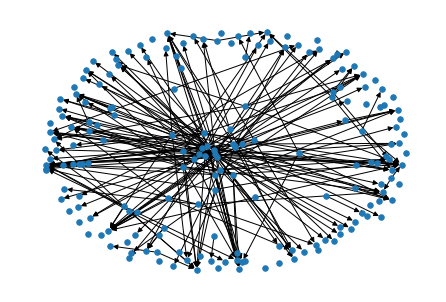

In [124]:
nx.draw(G, node_size = 30)